In [37]:
import joblib
import dalex as dx
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import lime.lime_tabular
import lime.lime_image
import warnings

sys.path.append('../')

import shap

plt.style.use('seaborn-paper')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=18)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rc('lines', markersize=10)

warnings.filterwarnings('ignore')
from src import Models, metrics
from sklearn.model_selection import train_test_split

In [38]:
df = pd.read_csv('../dataset/breast-cancer-wisconsin-processed.csv')
label = pd.read_csv('../dataset/breast-cancer-wisconsin-processed-label.csv')
data = pd.concat([df, label], axis=1)

In [39]:
# Split the data with stratified sampling
X = data.drop('diagnosis', axis=1)
y = data['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### All models has been set to default parameters and hyperparameter tuning has been done.

In [40]:
models, y_preds = Models.fit_and_predict_all(X_train, X_test, y_train, y_test, verbose=True)

Iteration: 1/1000, loss: 1.5163, accuracy: 0.4468
Iteration: 2/1000, loss: 0.8569, accuracy: 0.6574
Iteration: 3/1000, loss: 0.6109, accuracy: 0.7500
Iteration: 4/1000, loss: 0.6585, accuracy: 0.7292
Iteration: 5/1000, loss: 0.3791, accuracy: 0.8519
Iteration: 6/1000, loss: 0.3354, accuracy: 0.8241
Iteration: 7/1000, loss: 0.2557, accuracy: 0.8981
Iteration: 8/1000, loss: 0.2297, accuracy: 0.9051
Iteration: 9/1000, loss: 0.2047, accuracy: 0.9259
Iteration: 10/1000, loss: 0.1919, accuracy: 0.9444
Iteration: 11/1000, loss: 0.1817, accuracy: 0.9468
Iteration: 12/1000, loss: 0.1749, accuracy: 0.9537
Iteration: 13/1000, loss: 0.1694, accuracy: 0.9560
Iteration: 14/1000, loss: 0.1651, accuracy: 0.9583
Iteration: 15/1000, loss: 0.1613, accuracy: 0.9606
Iteration: 16/1000, loss: 0.1579, accuracy: 0.9630
Iteration: 17/1000, loss: 0.1549, accuracy: 0.9630
Iteration: 18/1000, loss: 0.1520, accuracy: 0.9630
Iteration: 19/1000, loss: 0.1494, accuracy: 0.9653
Iteration: 20/1000, loss: 0.1469, accura

In [41]:
models

{'Logistic Regression': <src.Models.LogisticRegression at 0x7fccea8d8e50>,
 'Linear Discriminant Analysis': <src.Models.LinearDiscriminantAnalysis at 0x7fcce9d8c210>,
 'Neural Network': NeuralNet(
   (fc1): Linear(in_features=30, out_features=100, bias=True)
   (fc2): Linear(in_features=100, out_features=2, bias=True)
 ),
 'Linear SVM': LinearSVC(C=1, max_iter=100, random_state=42, verbose=True),
 'CatBoost': <src.Models.CatBoostClassifier at 0x7fcce9d8c1d0>,
 'XGBoost': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
               gamma=0, gpu_id=-1, importance_type=None,
               interaction_constraints='', learning_rate=0.1, max_delta_step=0,
               max_depth=13, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=500, n_jobs=8,
               num_parallel_tree=1, predictor='auto', random_state=0,
               reg_alpha=0, reg_lam

In [42]:
for model_name, model in models.items():
    y_preds[model_name] = model.predict(X_test)

In [43]:
# Print classification report for each model
from sklearn.metrics import classification_report
for model_name, y_pred in y_preds.items():
    print(model_name)
    print(classification_report(y_test, y_pred))

LogisticRegression
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        71
           1       0.97      0.97      0.97        37

    accuracy                           0.98       108
   macro avg       0.98      0.98      0.98       108
weighted avg       0.98      0.98      0.98       108

LinearDiscriminantAnalysis
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        71
           1       1.00      0.92      0.96        37

    accuracy                           0.97       108
   macro avg       0.98      0.96      0.97       108
weighted avg       0.97      0.97      0.97       108

NeuralNet
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        71
           1       0.97      1.00      0.99        37

    accuracy                           0.99       108
   macro avg       0.99      0.99      0.99       108
weighted avg      

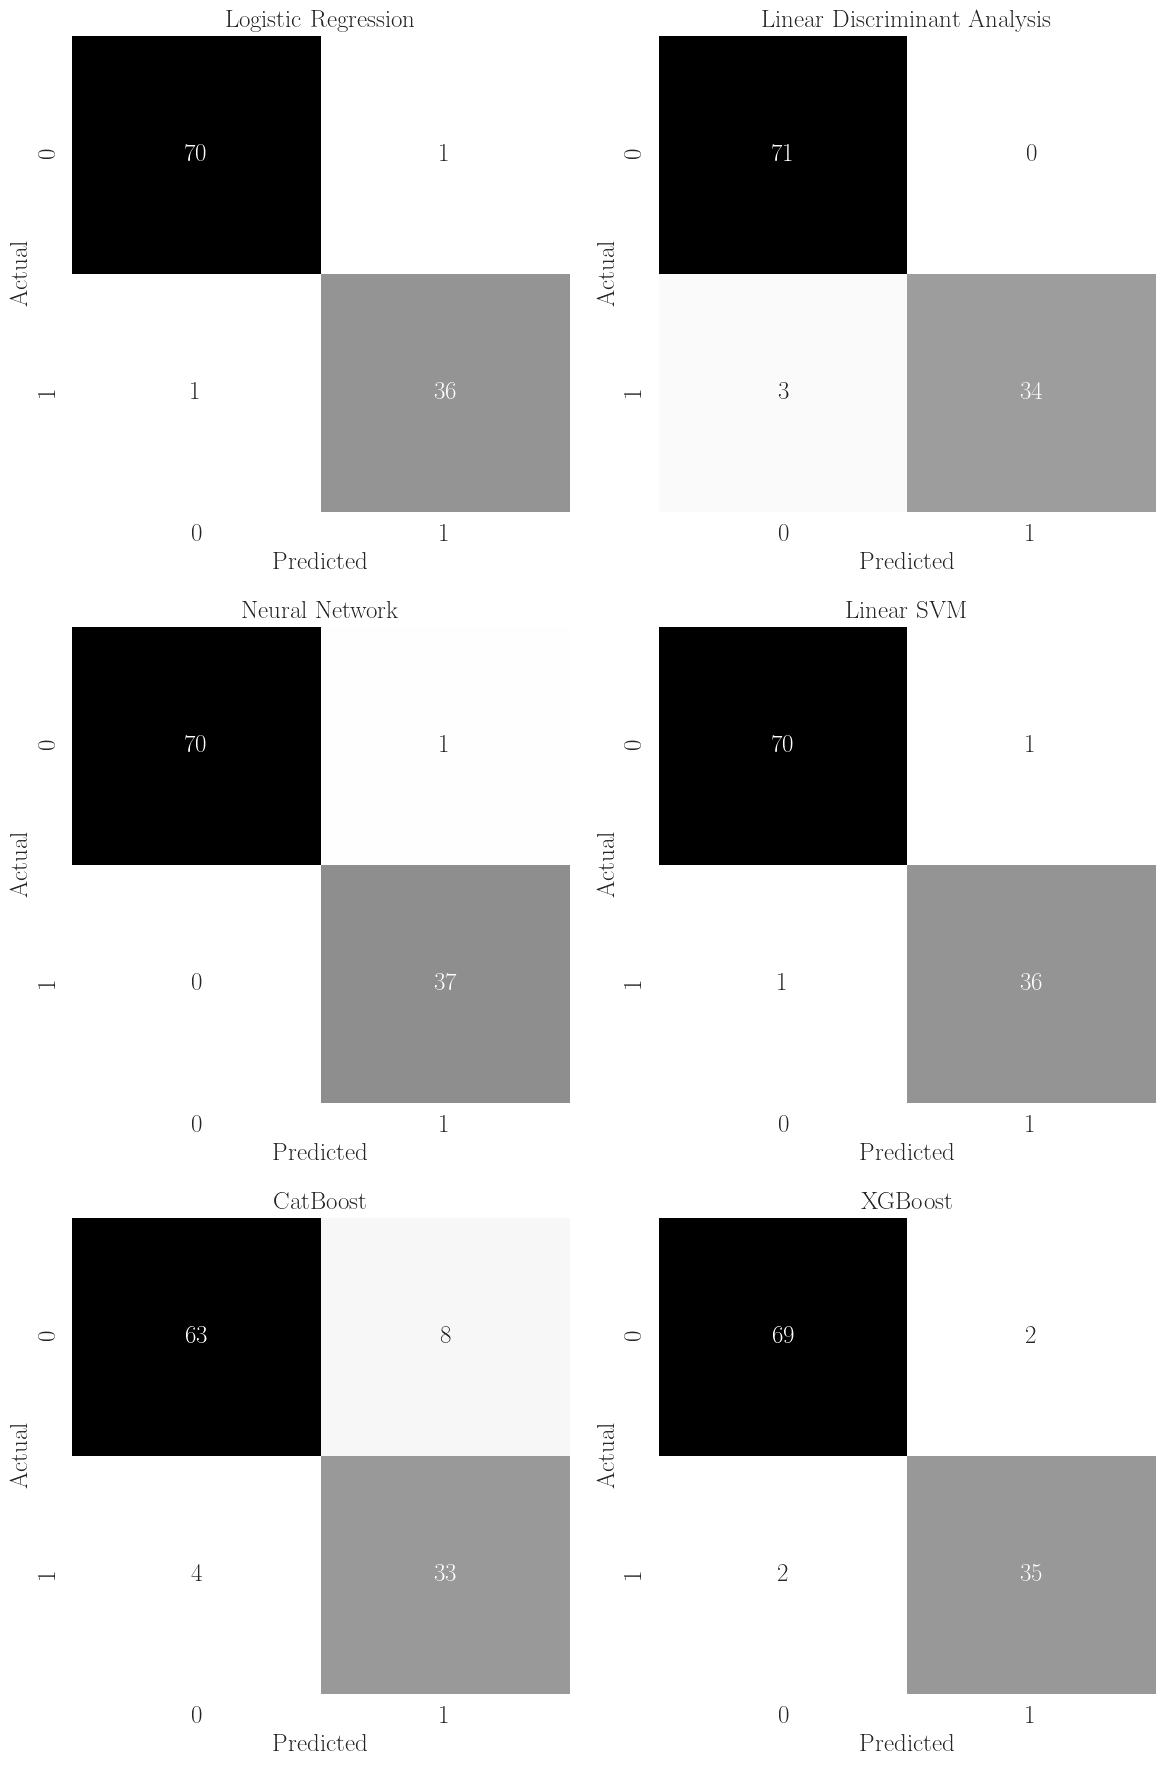

In [44]:
from sklearn.metrics import confusion_matrix
fig, axes = plt.subplots(3, 2, figsize=(12, 18))
axes = axes.flatten()
for i, (model_name, model) in enumerate(models.items()):
    cm = confusion_matrix(y_test, y_preds[model_name])
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap=plt.cm.Greys, cbar=False)
    axes[i].set_title(model_name)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
plt.tight_layout()
plt.savefig('../src/output_plots/confusion_matrix.pdf')
plt.show()

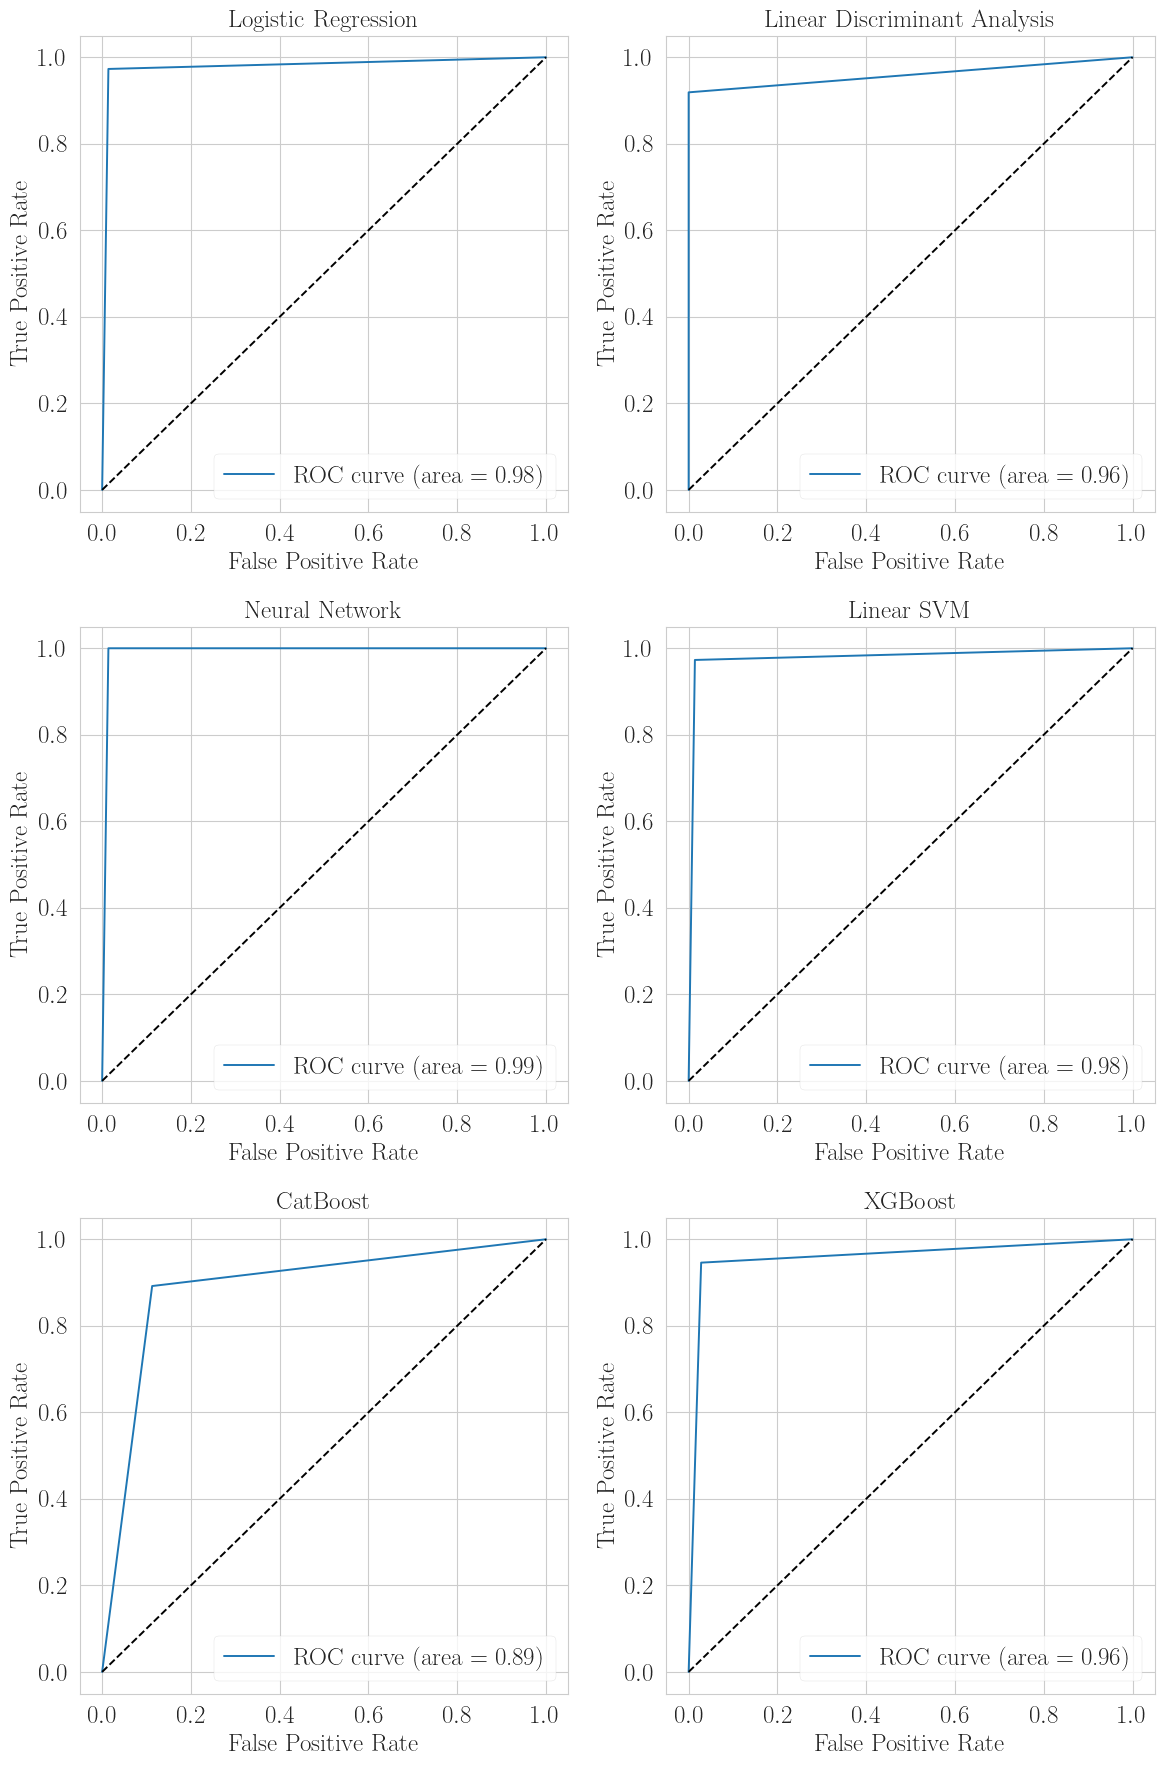

In [45]:
# Plot ROC curves for each model in the same plot
from sklearn.metrics import roc_curve, auc
fig, axes = plt.subplots(3, 2, figsize=(12, 18))
axes = axes.flatten()
for i, (model_name, model) in enumerate(models.items()):
    fpr, tpr, _ = roc_curve(y_test, y_preds[model_name])
    roc_auc = auc(fpr, tpr)
    axes[i].plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    axes[i].plot([0, 1], [0, 1], 'k--')
    axes[i].set_xlim([-0.05, 1.05])
    axes[i].set_ylim([-0.05, 1.05])
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].set_title(model_name)
    axes[i].legend(loc="lower right")
plt.tight_layout()
plt.savefig('../src/output_plots/roc_curve.pdf')
plt.show()

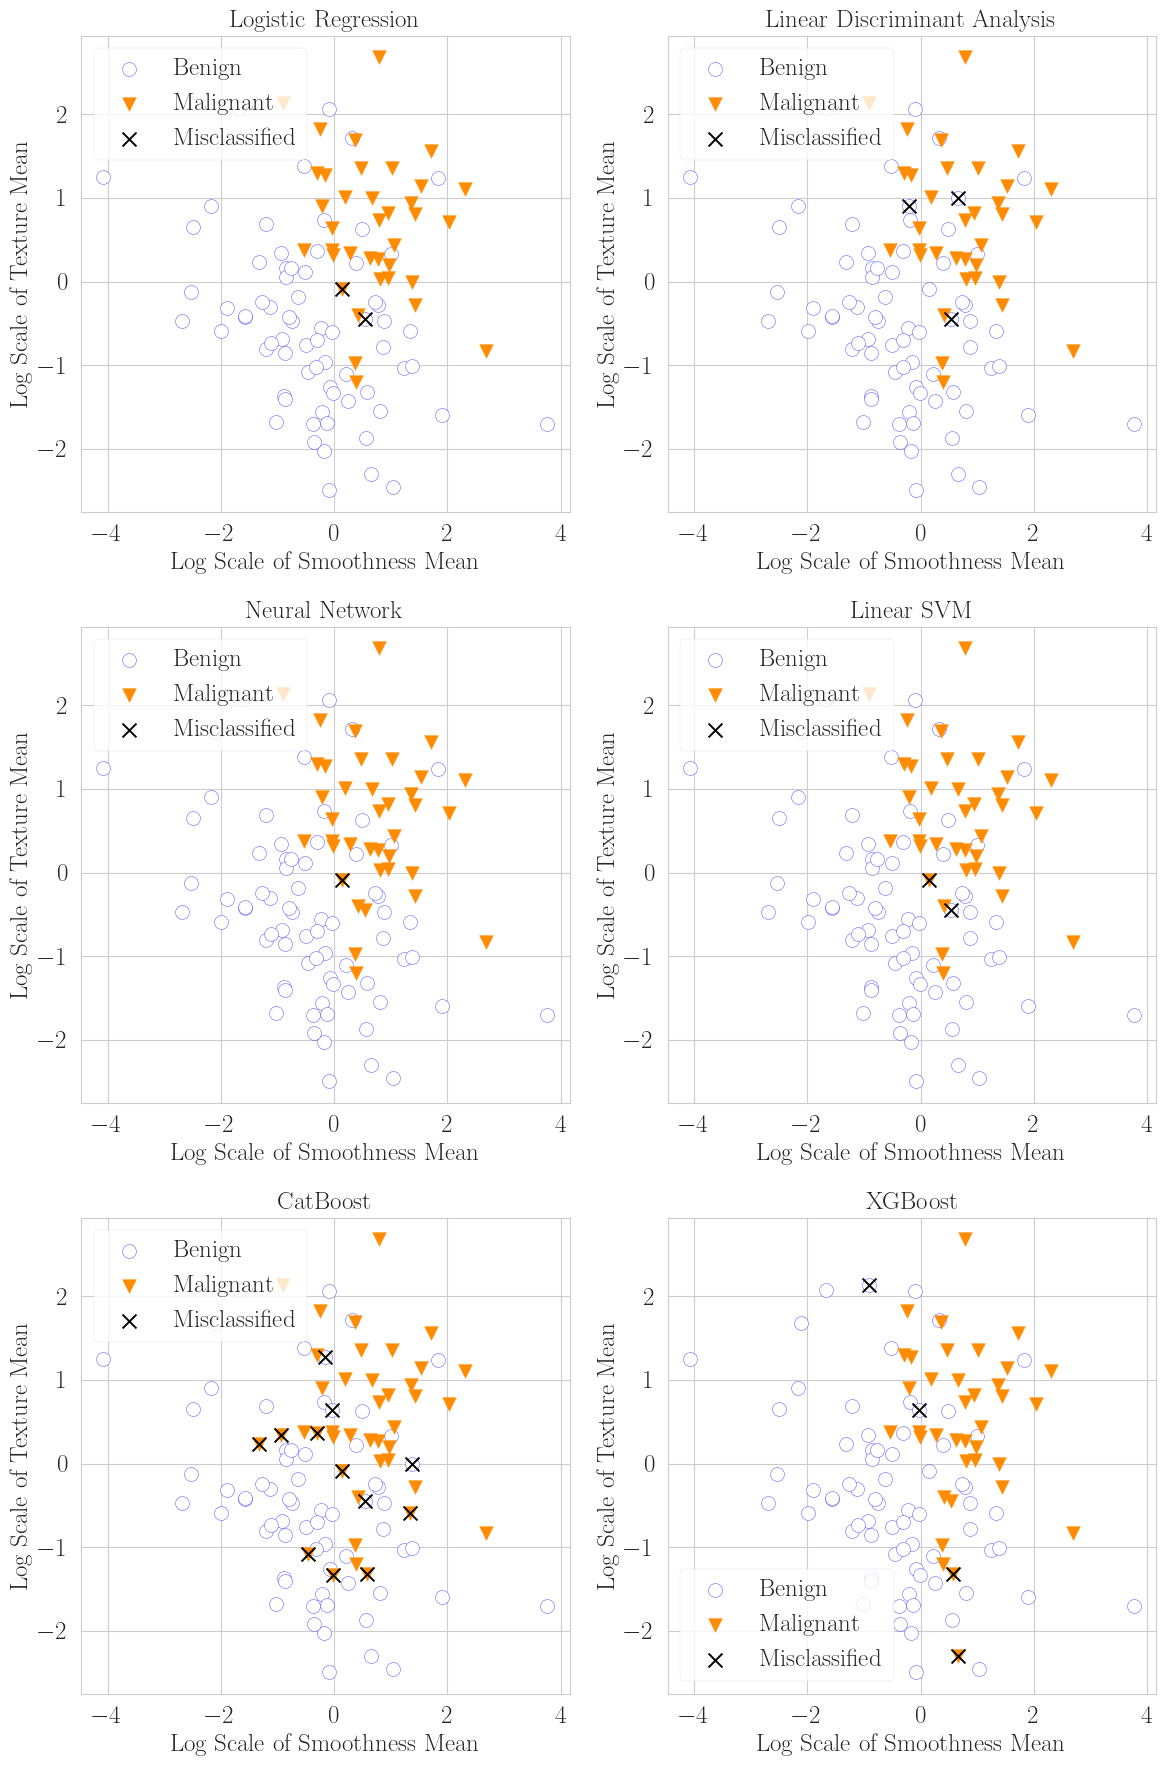

In [46]:
# Plot prediction set for each model
fig, axes = plt.subplots(3, 2, figsize=(12, 18))
axes = axes.flatten()
for i, (model_name, model) in enumerate(models.items()):
    y_pred = y_preds[model_name]
    axes[i].scatter(X_test[y_pred == 0]['smoothness_mean_log'], X_test[y_pred == 0]['texture_mean_log'], marker='o',
            label='Benign', s=100, edgecolors='blue', facecolors='white')
    axes[i].scatter(X_test[y_pred == 1]['smoothness_mean_log'], X_test[y_pred == 1]['texture_mean_log'], marker='v',
            label='Malignant', s=100, edgecolors='darkorange', facecolors='darkorange')
    axes[i].scatter(X_test[y_pred != y_test]['smoothness_mean_log'], X_test[y_pred != y_test]['texture_mean_log'], marker='x',
            label='Misclassified', s=100, edgecolors='black', facecolors='black')
    axes[i].set_xlabel('Log Scale of Smoothness Mean')
    axes[i].set_ylabel('Log Scale of Texture Mean')
    axes[i].set_title(model_name)
    axes[i].legend()
plt.tight_layout()
# Export to latex
plt.savefig('../src/output_plots/prediction_set.pdf')
plt.show()

In [55]:
# Create a dataframe for model performance with accuracy, precision, recall, f1-score, and AUC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# Round the values to 2 decimal places each value
model_performance = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC'])
for model_name, model in models.items():
    y_pred = y_preds[model_name]
    model_performance.loc[model_name, 'Accuracy'] = accuracy_score(y_test, y_pred)
    model_performance.loc[model_name, 'Precision'] = precision_score(y_test, y_pred)
    model_performance.loc[model_name, 'Recall'] = recall_score(y_test, y_pred)
    model_performance.loc[model_name, 'F1-Score'] = f1_score(y_test, y_pred)
    model_performance.loc[model_name, 'AUC'] = roc_auc_score(y_test, y_pred)
model_performance.to_latex('../reports/model_performance.tex')

In [56]:
model_performance

,Accuracy,Precision,Recall,F1-Score,AUC
Logistic Regression,0.981481,0.972973,0.972973,0.972973,0.979444
Linear Discriminant Analysis,0.972222,1.0,0.918919,0.957746,0.959459
Neural Network,0.990741,0.973684,1.0,0.986667,0.992958
Linear SVM,0.981481,0.972973,0.972973,0.972973,0.979444
CatBoost,0.888889,0.804878,0.891892,0.846154,0.889608
XGBoost,0.962963,0.945946,0.945946,0.945946,0.958888
